### Preprocessing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [26]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import tarfile
from google.colab import drive
import os
import pandas as pd
import csv
from shutil import copyfile, copy2, copy
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from numpy import argmax
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from keras_preprocessing.image import ImageDataGenerator
from textwrap import wrap
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, CategoricalCrossentropy
from tensorflow_addons.metrics import F1Score
import json
import datetime
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools

In [4]:
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/freiburg_groceries_dataset.tar.gz", "r")
tar.extractall('/content')

In [5]:
dataset_path = '/content/images'
new_path = '/content/freiburg_groceries'
train_path = '/content/freiburg_groceries/train'
validation_path = '/content/freiburg_groceries/validation'
evaluation_path = '/content/freiburg_groceries/evaluation'

if not os.path.exists(new_path):
    os.makedirs(new_path)

if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(os.path.join(train_path, 'images'))

if not os.path.exists(validation_path):
    os.makedirs(validation_path)
    os.makedirs(os.path.join(validation_path, 'images'))

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
    os.makedirs(os.path.join(evaluation_path, 'images'))

In [6]:
dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(dataset_path):
  for product_file in os.listdir(os.path.join(dataset_path, product)):
    dataset['file_name'].append(os.path.join(dataset_path, product, product_file))
    dataset['label'].append(product)

dataset_df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [7]:
train_validate_filenames, evaluation_filenames, train_validate_labels, evaluation_labels = train_test_split(dataset_df['file_name'], dataset_df['label'], train_size=0.8, random_state=42, stratify=dataset_df['label'])

train_validate_df = pd.DataFrame(zip(train_validate_filenames, train_validate_labels), columns=['file_name', 'label'])

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(train_validate_df['file_name'], train_validate_df['label'], train_size=0.875, random_state=42, stratify=train_validate_df['label'])

train_df = pd.DataFrame(zip(train_filenames, train_labels), columns=['file_name', 'label'])

validation_df = pd.DataFrame(zip(validation_filenames, validation_labels), columns=['file_name', 'label'])

evaluation_df = pd.DataFrame(zip(evaluation_filenames, evaluation_labels), columns=['file_name', 'label'])

In [8]:
with open(os.path.join(train_path, 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(train_path, 'images', split[-1]))

In [9]:
with open(os.path.join(validation_path, 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(validation_path, 'images', split[-1]))

In [10]:
with open(os.path.join(evaluation_path, 'evaluation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(evaluation_filenames, evaluation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(evaluation_path, 'images', split[-1]))

## Defining data augmentations

Found 3462 validated image filenames belonging to 25 classes.
Found 495 validated image filenames belonging to 25 classes.
Found 990 validated image filenames belonging to 25 classes.


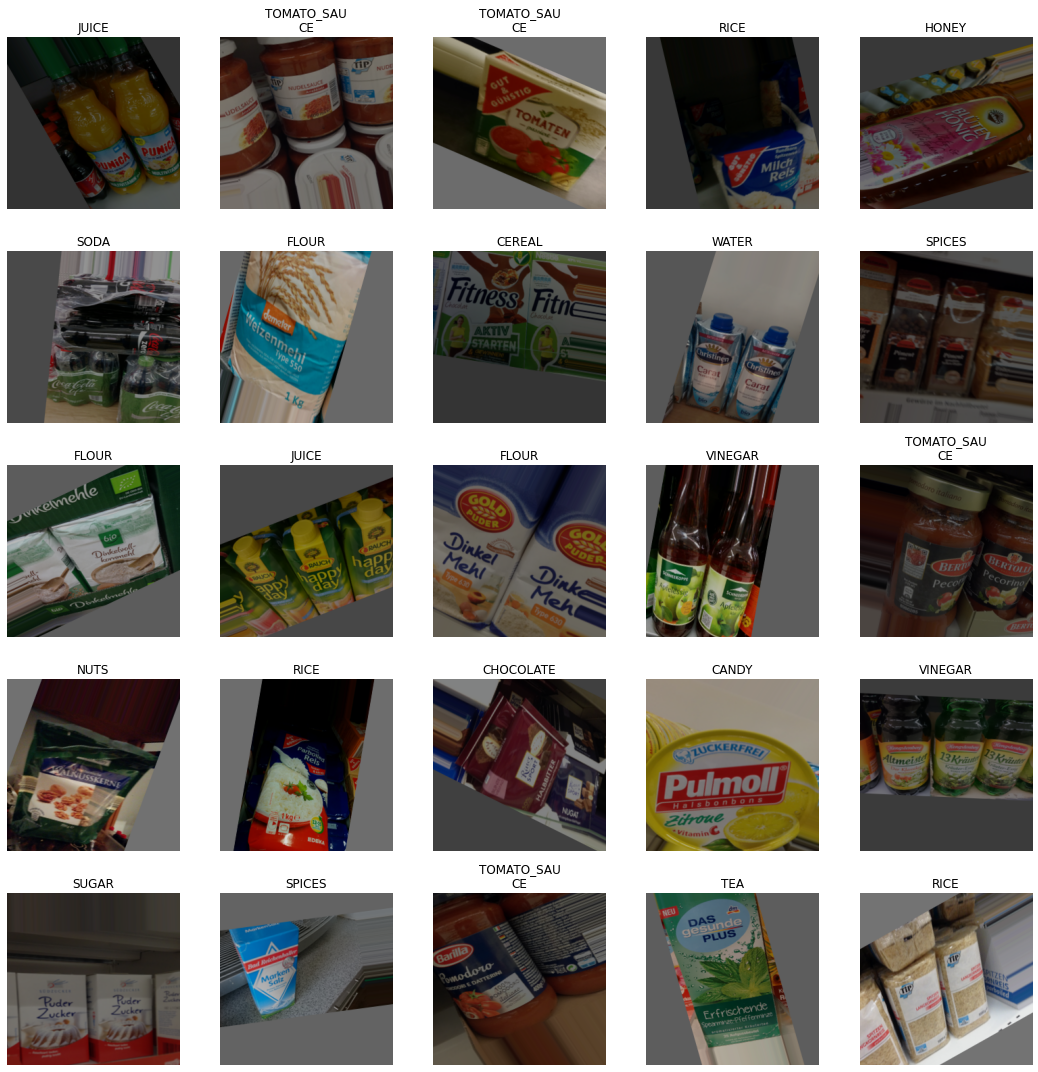

In [12]:
%matplotlib inline

IMG_SIZE = 256
BATCH_SIZE = 128

train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(validation_path, 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(evaluation_path, 'evaluation.csv'))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=30,  
    zoom_range = 0.2,
    shear_range = 0.2,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=os.path.join(train_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=os.path.join(validation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=os.path.join(evaluation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    inverted = class_indices_inverted[argmax(y[num])]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

## Defining the Model

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )
base_model.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


In [17]:
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.4)
dense_layer_1 = tf.keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))
leaky_relu_layer = tf.keras.layers.LeakyReLU()
dense_layer_2 = tf.keras.layers.Dense(25)
activation_layer = tf.keras.layers.Activation('softmax', dtype='float64', name='output')

In [18]:
num_classes = len(train_generator.class_indices)
metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    CategoricalCrossentropy(label_smoothing=0.3),
    F1Score(name='f1score',num_classes=num_classes)]

In [19]:
model = tf.keras.Sequential([
  base_model,
  global_max_layer,
  dropout_layer,
  dense_layer_1,
  leaky_relu_layer,
  dense_layer_2,
  activation_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                3225      
_________________________________________________________________
output (Activation)          (None, 25)               

## Training the Model

In [21]:
num_epochs = 1

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

28/28 [==============================] - 77s 3s/step - loss: 5.5137 - categorical_accuracy: 0.0624 - precision: 0.0576 - recall: 0.0222 - auc: 0.5386 - categorical_crossentropy: 5.3961 - f1score: 0.0534 - val_loss: 3.4958 - val_categorical_accuracy: 0.1010 - val_precision: 0.1000 - val_recall: 0.0020 - val_auc: 0.6278 - val_categorical_crossentropy: 3.5083 - val_f1score: 0.0805


## Evaluation

In [ ]:
model.evaluate(evaluation_generator)

8/8 [==============================] - 12s 2s/step - loss: 1.3634 - categorical_accuracy: 0.6061 - precision: 0.8046 - recall: 0.4202 - auc: 0.9598 - categorical_crossentropy: 2.6827 - f1score: 0.5901


[1.3634470701217651,
 0.6060606241226196,
 0.8046421408653259,
 0.42020201683044434,
 0.9598475694656372,
 2.6826720237731934,
 array([0.8076922 , 0.62295085, 0.6933333 , 0.5045045 , 0.5869565 ,
        0.647619  , 0.5371428 , 0.6923078 , 0.61538464, 0.4888889 ,
        0.72093016, 0.77192986, 0.5438596 , 0.5517242 , 0.5172414 ,
        0.6666667 , 0.45614034, 0.43478262, 0.58064514, 0.3076923 ,
        0.4       , 0.61855674, 0.45945945, 0.64615387, 0.88      ],
       dtype=float32)]

In [47]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(16,16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [28]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float32')/255
    x = np.expand_dims(x, axis=0)
    return x

In [38]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_name"]:
    x = get_image(os.path.join(evaluation_path, 'images', path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

Confusion matrix, without normalization


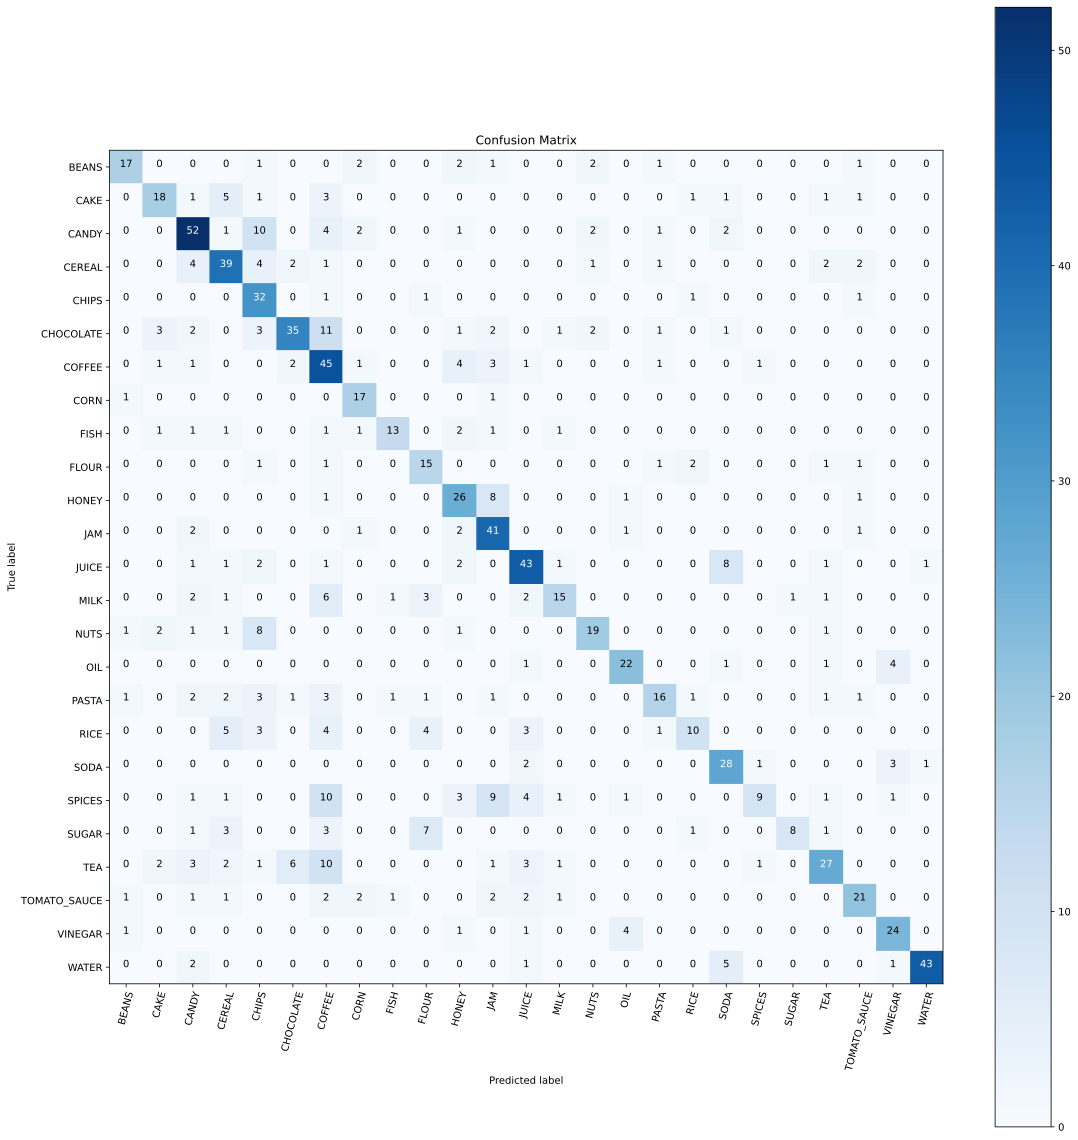

In [48]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', file_name='confusion_matrix_freiburg')

## Save and Load Model & Results

In [37]:
date_str_now = datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S")

#model_path =  '/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/InceptionResNetV2_imagenet_{}.h5'.format(date_str_now)
#model.save(model_path) 
model.load_weights('/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/InceptionResNetV2_imagenet_29_06_20_17_17_02.h5')

In [ ]:
hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/history/InceptionResNetV2_{}_history.json'.format(date_str_now)
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)